# 12 Kinds of People
#### A Tour of Unstructured Data

I scraped the profiles of several thousand users on a popular website. Among the data on each profile is their favorite books, movies, TV shows, and even food. But this data is hard to make sense of; it's just a list of words.

Using some natural language processing, however, we can tame this data and discover some interesting insights.

In [1]:
import pandas as pd

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation, digits

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import recall_score, accuracy_score

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# I've pre-wrangled and saved the data, but we'll still need to do a bit more work
data = pd.read_csv('favorites_data.csv')
del data['Unnamed: 0']

# Dataframe info
print('Shape:',data.shape)
print('Columns:', data.columns)

# Sample entries
data.sample(5)

Shape: (7116, 2)
Columns: Index(['favorites', 'length'], dtype='object')


,favorites,length
5745,"Capital by Karl Marx, Dialetic of Enlightment,...",203
5838,"Books/movies : The Green Mile, To Kill A Mocki...",324
3968,"Read: Inferno of Dante, Into Thin Air, Mountai...",967
3640,In no particular order...Books: Princess Bride...,590
6816,My all time favorite book series is Stephen Ki...,425


In [3]:
# Processing the text using NLP

st = SnowballStemmer(language='english')

# Irrelevant words I noticed people using (e.g. "I admit I mostly watch new movies").
other_stopwords = ['I', 'I’m', 'about', 'absolutely', 'actuality', 'admit', 'almost', 'also', 'am', 'anything',
                   'area', 'asked', 'at', 'authors', 'back', 'better', 'big', 'book', 'books', 'born', 'can',
                   'cant', 'coast', 'com', 'cook', 'could', 'couple', 'currently', 'do', 'doing', 'eat', 'else',
                   'enjoy', 'enjoyed', 'especially', 'etc', 'even', 'everything', 'fav', 'fave', 'favorite',
                   'favourite', 'favorites', 'favourites', 'fiction', 'films', 'find', 'finished', 'first',
                   'food', 'food', 'generally', 'get', 'go', 'gonna', 'good', 'got', 'great', 'if', 'i’m',
                   'include', 'keep', 'know', 'least', 'like', 'list', 'listen', 'listening', 'little', 'live',
                   'lot', 'love', 'loved', 'mainly', 'make', 'man', 'many', 'me', 'most', 'mostly', 'movie',
                   'movies', 'much', 'music', 'my', 'nan', 'need', 'never', 'new', 'next', 'often', 'on',
                   'one', 'particular', 'person', 'personality', 'please', 'pretty', 'probably', 'profile',
                   'raised', 'read', 'reading', 'really', 'recently', 'recommend', 'say', 'see', 'seem',
                   'seen', 'self', 'series', 'should', 'show', 'shows','something', 'sometimes', 'spend'
                   'still', 'stuff', 'summary', 'take', 'tells', 'thing', 'things', 'think', 'thinking',
                   'though', 'time', 'to', 'try', 'tv', 'typical', 'unless', 'use', 'usually', 'wan', 'wanna',
                   'want', 'watch', 'watching', 'way', 'well', 'went', 'what', 'with', 'without',
                   'would', 'www', 'you', 'youtube', '•', '↣'] 

def text_process(text, stem=False, stops=True):
    # Stopwords to remove
    stopword_set = set(stopwords.words('english') + list(punctuation) +\
                        list(digits) + other_stopwords)
    
    # Removes punctuation inside of words (e.g., hip-hop -> hip hop)
    for i in list(punctuation):
        text = text.replace(i, ' ')
        
    # Clean the words
    token = word_tokenize(text)
    cleaned = [word.lower() for word in token]
    
    # In case I want to turn off stopwords
    if stops == True:
        cleaned = [word for word in cleaned if word not in stopword_set]
    
    # Stem the words (optional)
    if stem == True:
        cleaned = [st.stem(word) for word in cleaned]
    
    return cleaned

In [4]:
# Count the most popular words to get a feel for what people mention

things_liked = data['favorites'].apply(text_process).copy()

things_master_list = []

for i in range(len(things_liked)):
    try:
        for j in things_liked[i]:
            things_master_list.append(j)
    except Exception:
        continue

# Some entries are blank, so let's remove them.
bad_entries = [[],]

things_master_list = [i for i in things_master_list if i not in bad_entries]

print('Number of words in list:', len(things_master_list))

Number of words in list: 343570


In [5]:
results = Counter(things_master_list)
results.most_common(40)

[('rock', 1411),
 ('game', 1328),
 ('black', 1046),
 ('dead', 1003),
 ('thrones', 992),
 ('life', 988),
 ('american', 961),
 ('house', 938),
 ('always', 933),
 ('horror', 908),
 ('country', 812),
 ('bad', 775),
 ('harry', 771),
 ('star', 730),
 ('potter', 711),
 ('sushi', 688),
 ('old', 657),
 ('walking', 650),
 ('john', 619),
 ('italian', 601),
 ('pop', 598),
 ('mexican', 585),
 ('thai', 579),
 ('world', 577),
 ('fan', 574),
 ('girl', 569),
 ('last', 566),
 ('breaking', 560),
 ('family', 548),
 ('hop', 546),
 ('david', 542),
 ('hip', 536),
 ('men', 533),
 ('day', 520),
 ('comedy', 519),
 ('people', 503),
 ('story', 491),
 ('indian', 484),
 ('city', 482),
 ('metal', 481)]

This a bag-of-words approach so it requires some pop-culture domain knowledge to interpret. Here's what I notice in the list:

1. Rock music
2. Game of Thrones
3. The Walking Dead
4. Harry Potter
5. Sushi
6. Italian food
7. Pop music
8. Thai food
9. Mexican food
10. Hip-hop music
 
Things that "might" be mentioned (in no particular order):
1. This American Life
2. Black Mirror
3. Orange is the New Black
4. Clockwork Orange
5. American Horror Story
6. House, M.D.
7. House music
8. Star Wars
9. Star Trek
10. Family Guy
11. Modern Family

These are my educated guesses. People might be huge fans of *Little House on the Prairie*, but I doubt it.

# Creating the DataFrame
This is where the real magic happens. I iterate over each word used, then (if necessary) create a new column with that word and assign it a value of 1. We can then look at correlations and create a simple recommender system.

I saved the results to a csv, then put the code in a function. This will prove useful when we cluster the data and need to change the parameters.

In [6]:
def favorites_df(mentions=20, save=True):
    df = pd.DataFrame()

    for i in range(len(data)):
        things_list = []
        things_liked = text_process(data.iloc[i]['favorites'], stem=False)
        if len(things_liked) > 0:
            for j in things_liked:
                if results[j] >= mentions: #set a threshold
                    df.set_value(i, j, 1)

    df.fillna(0, inplace=True)
    
    if save == True:
        df.to_csv('favorites_processed.csv', encoding='utf-8')
    
    return df

In [7]:
# Retrieving the csv I saved with the previous function
df = pd.read_csv('favorites_processed.csv')

df.head(3)

,broken,social,scissorhands,calvino,e,solid,moment,real,old,religion,...,lucy,patterson,rand,jump,dessert,elf,watcher,narrow,screen,☩
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Building my simpler recommender system

def corrs(corr_item=df['thrones'], df=df):
    '''
    Finds correlated words, then sorts by absolute value to account for
    strong negative correlations.
    '''
    cor = df.select_dtypes(include=[np.number]).corrwith(corr_item)
    df = pd.DataFrame(cor.sort_values(ascending=False),columns=['corr'])
    df['absol'] = np.abs(df['corr'])
    return df[df.absol < 1].sort_values('absol', ascending=False)['corr']         

In [9]:
# Titles that were ambiguous from our top results, or might
# otherwise be hard to find. Not perfect, but works well enough.

df['always_sunny'] = np.where((df.always == 1) & (df.sunny == 1), 1, 0)
df['american_dad'] = np.where((df.american == 1) & (df.dad == 1) & (df.horror == 0), 1, 0)
df['american_horror_story'] = np.where((df.american == 1) & (df.dad == 0) & (df.horror == 1), 1, 0)
df['big_bang_theory'] = np.where((df.bang == 1) & (df.theory == 1), 1, 0)
df['black_mirror'] = np.where((df.black == 1) & (df.mirror == 1), 1, 0)
df['clockwork_orange'] = np.where((df.clockwork == 1) & (df.orange == 1), 1, 0)

# People love to point out that they hate country music.
df['country'] = np.where((df.country == 1) & (df['except'] == 0), 1, 0) 

df['crazy_ex_girlfriend'] = np.where((df.crazy == 1) & (df.ex == 1), 1, 0)
df['criminal_minds'] = np.where((df.criminal == 1) & (df.minds == 1), 1, 0)
df['family_guy'] = np.where((df.family == 1) & (df.guy == 1), 1, 0)
df['final_fantasy'] = np.where((df.final == 1) & (df.fantasy == 1), 1, 0)
df['game_of_thrones'] = np.where((df.game == 1) & (df.thrones == 1), 1, 0)
df['lord_of_the_rings'] = np.where((df.lord == 1) & (df.rings == 1), 1, 0)
df['modern_family'] = np.where((df.modern == 1) & (df.family == 1), 1, 0)
df['name_of_the_wind'] = np.where((df.wind == 1) & (df.name == 1), 1, 0) # My favorite book!
df['orange_is_the_new_black'] = np.where((df.black == 1) & (df.orange == 1), 1, 0)
df['pans_labyrinth'] = np.where((df.pan == 1) & (df.labyrinth == 1), 1, 0)
df['princess_bride'] = np.where((df.princess == 1) & (df.bride == 1), 1, 0)
df['south_park'] = np.where((df.south == 1) & (df.park == 1), 1, 0)
df['star_trek'] = np.where((df.star == 1) & (df.trek == 1), 1, 0) # Really, "trek" would be enough.
df['star_wars'] = np.where((df.star == 1) & (df.wars == 1), 1, 0)
df['the_office'] = np.where((df.office == 1) & (df.space == 0), 1, 0)
df['this_american_life'] = np.where((df.american == 1) & (df.life == 1), 1, 0)
df['whose_line'] = np.where((df.whose == 1) & (df.line == 1), 1, 0)

# One of my favorite shows, and a huge pain to search for!
df['lost_tv_show'] = np.where((df.lost == 1) & (df.translation == 0) &\
                              (df.boys == 0) & (df.paradise == 0) &\
                              (df.getting == 0) & (df.world == 0) &\
                              (df.souls == 0) & (df.children == 0) &\
                              (df.girl == 0), 1, 0)


In [10]:
corrs(df.inception).head(10)

matrix          0.131394
interstellar    0.126193
memento         0.111728
500             0.104884
linkin          0.102744
knight          0.099465
fight           0.089651
club            0.088107
hunting         0.087711
nemo            0.085528
Name: corr, dtype: float64

People who like Inception also tend to like:
- The Matrix
- Interstellar
- Memento
- 500 Days of Summer
- Linkin Park
- The Dark Knight
- Fight Club
- Hunting Nemo

Wait, that's not the name of the movie! Does "hunting" refer to *Good Will Hunting*? Let's make sure.

In [11]:
corrs(df['hunting']).head(10)

bourne           0.151105
beautiful        0.109918
frozen           0.093225
redemption       0.092339
bareilles        0.090978
inception        0.087711
departed         0.087251
society          0.084507
shawshank        0.081715
mediterranean    0.080939
Name: corr, dtype: float64

It would appear so. It's interesting to note that it's pretty common to simply be a "Matt Damon" fan (e.g., Jason Bourne, The Departed).

So, what about *Good Will Hunting*?

In [12]:
#corrs(df['will'])

I won't run it, but this results in a KeyError! The problem with my stopwords is that they sometimes filter out names of titles, such as "Finding" Nemo or Good "Will" Hunting.

However, I'd argue this is more a problem with unstructured data, than the use of stopwords.

# Clusters
What if there are certain "types" of people in terms of personal tastes? A cluster analysis could uncover this.

In [13]:
# Create a new dataframe. We need to increase the popularity
# threshold from 20 to 50 to reduce dimensionality.

df_popular = favorites_df(mentions=50, save=False)

In [14]:
df_popular.shape

(7073, 1400)

There's no avoiding it: We'll have to reduce the number of dimensions in order to perform a cluster analysis. Let's see if we can find a point of diminishing returns.

In [15]:
from sklearn.decomposition import PCA

variance_dict = {}

for i in range(1,1100,100):
    pca = PCA(n_components=i, whiten=True).fit(df_popular)
    variance_dict[i] = sum(pca.explained_variance_ratio_)

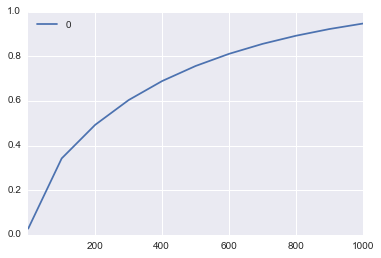

In [16]:
vdf = pd.DataFrame([variance_dict]).T.plot()

There's an elbow at approximately 100, but that's still too many features for this data set.

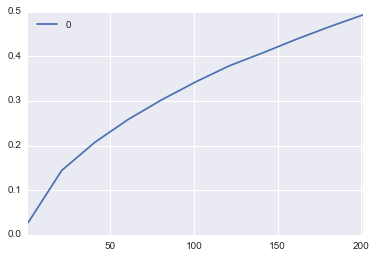

In [17]:
variance_dict = {}

for i in range(1,210,20):
    pca = PCA(n_components=i, whiten=True).fit(df_popular)
    variance_dict[i] = sum(pca.explained_variance_ratio_)
    
pd.DataFrame([variance_dict]).T.plot()

20 appears to be another good option. However, after much trial and error, I discovered that it's most effective to capture about 10% of the variance with only 10 features. It makes our clustering decisions much easier.

In [18]:
pca = PCA(n_components=10, whiten=True).fit(df_popular)

dframe = pca.transform(df_popular)

print('PCA explained variance:', sum(pca.explained_variance_ratio_))
print('Shape:', dframe.shape)

PCA explained variance: 0.0944641399422
Shape: (7073, 10)


We're only catching a tiny fraction of the variance, but it'll have to do.

Next question: How many clusters should we have?

In [19]:
# Inertia measures the average distance to the nearest centroid.
# We want it to be low, but adding more clusters is always going
# to reduce it. So we need to find a point of diminishing returns.

kdict = {}

for i in range(2,20):
    clf = KMeans(n_clusters=i)
    clf.fit(dframe)
    kdict[i] = clf.inertia_

kframe = pd.DataFrame([kdict]).T
kframe.columns = ['inertia']

# Calculate the improvement as a percentage
kframe['improvement'] = (kframe['inertia'].shift(1) - kframe['inertia'])/kframe['inertia'].shift(1)

kframe

,inertia,improvement
2,64337.311835,NaN
3,59860.945783,0.069577
4,55662.874914,0.070130
5,52696.798054,0.053286
6,49684.660504,0.057160
7,46762.733374,0.058809
8,44752.937465,0.042979
9,42655.432837,0.046869
10,40929.314653,0.040467
11,39432.124966,0.036580


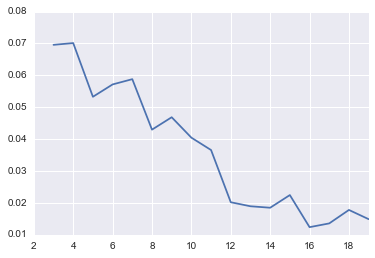

In [20]:
kframe.improvement.plot()

12 appears to be a good number of clusters.

In [21]:
clf = KMeans(n_clusters=12)
clf.fit(df_popular)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
df_popular['cluster'] = clf.labels_ + 1

In [23]:
groups = df_popular.groupby('cluster').mean()

# Shrink the dataframe to only mention the most common words.
groups = groups[(groups > .1)]
groups.dropna(how='all', axis=1, inplace=True)

In [24]:
# I created a graphic below this output; scroll down
# if you just want to see the highlights!

for i in range(len(groups)):
    print('Cluster', str(i+1))
    for j in groups.columns:
        if groups.iloc[i][j] > .2:
            print(j, end=', ')
    print()
    print()

Cluster 1
sushi, mexican, thai, indian, italian, 

Cluster 2
life, house, black, american, development, rock, bad, john, city, 

Cluster 3
house, bad, walking, dead, game, thrones, harry, potter, 

Cluster 4
real, old, talk, house, cards, black, american, breaking, bad, thai, folk, indian, vietnamese, documentaries, always, sunny, philadelphia, feel, italian, soul, band, john, bill, school, coffee, wild, alchemist, top, biographies, light, cheese, daily, true, french, men, indie, season, late, blues, still, hbo, name, days, songs, seinfeld, mad, spicy, david, classics, peter, hemingway, tarantino, coen, others, allen, detective, woody, eric, rom, meet, narcos, perfect, curb, enthusiasm, alabama, easy, special, getting, brothers, political, kubrick, sucker, mother, wes, anderson, written, foreign, year, sia, brother, williams, jason, joan, 

Cluster 5
old, sunshine, mind, life, house, orange, black, family, guy, american, arrested, development, rock, girl, breaking, bad, walking, dead, 

![12 Clusters](http://databrain.org/wp-content/uploads/2017/01/Clusters.png)

# Machine Learning Your Tastes

Is it possible to use machine learning on this data? Let's find out!

I've heard lots of good things about Margaret Atwood, but I've never read her books.

Let's say I like Game of Thrones, Breaking Bad, Lost, Ferris Bueller, and The Walking Dead. Would I like Margaret Atwood?

In [25]:
my_tastes = {'game_of_thrones': 1, 'breaking': 1, 'bad': 1, 'walking': 1, 'dead': 1,
             'lost_tv_show': 1, 'name_of_the_wind': 1, 'ferris': 1, 'bueller': 1}

df = df.append(my_tastes, ignore_index=True).fillna(0)

In [26]:
x = df.copy()
y = x.pop('atwood')

# Remove her book titles
del x['margaret']
del x['handmaid']
del x['tale']
del x['heart']
del x['goes']
del x['last']
del x['year']

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.20)

clf = RandomForestClassifier(n_estimators=500) # We need a lot of estimators to create precise predictions.
clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)
pred_proba = clf.predict_proba(xtest)

accuracy_score(ytest, pred)

0.98660084626234135

In [28]:
pred.sum()

0.0

We have a problem! There's a huge class imbalance, and the model is going to be 99% accurate just by predicting that no one likes Margaret Atwood.

I'm quite willing to have some false positives, so let's create a custom set of predictions.

In [29]:
atwood_average = pred_proba[:,1].mean()
atwood_std = pred_proba[:,1].std()

print("Average probability of liking Margaret Atwood:", atwood_average)
print("Standard deviation:", atwood_std)

Average probability of liking Margaret Atwood: 0.0058293370945
Standard deviation: 0.0131091409547


Let's combine them, and say that if your probability is one standard deviation above the average, then you're predicted to like her.

In [30]:
predicted_to_like = atwood_average + atwood_std
pred_custom = []

for i in pred_proba[:,1]:
    if i >= predicted_to_like:
        pred_custom.append(1)
    else:
        pred_custom.append(0)

np.sum(pred_custom)

130

Woohoo! Now many people are predicted to like her. Let's now evaluate this using recall score, rather than accuracy. This benchmark is more appropriate, considering I'm okay with false positives.

In [31]:
recall_score(ytest, pred_custom)

0.26315789473684209

In [32]:
# Compare it to my original predictions. 
recall_score(ytest, pred)

0.0

Much better!

In [33]:
# Feature importances
atwood = pd.DataFrame([df.columns, clf.feature_importances_, ]).transpose()
atwood.columns = ['feature', 'importance']

atwood.sort_values('importance', ascending=False).head(10)

,feature,importance
2645,mann,0.00512163
1220,eggers,0.00395789
2466,dwarf,0.00366785
427,slow,0.00327189
1995,craft,0.00321687
2120,rome,0.00320266
2646,neal,0.00306542
768,douglas,0.00268902
777,zone,0.00266965
2052,touch,0.00258543


We went off on a tangent. The original question was whether I'd like Margaret Atwood.

In [34]:
pred_me = clf.predict_proba(x.iloc[-1].reshape(1, -1))

In [35]:
pred_me[0,1]

0.0

Apparently Margaret Atwood isn't for me. In fact, the model was bold enough to assign a 0% probability! Which makes me wonder -- is it assigning binary labels to everyone?

In [36]:
clf.predict_proba(x)[:,1][:5]

array([ 0.   ,  0.006,  0.002,  0.002,  0.   ])

Nope, it just really thinks I won't like her. Thanks, model!

There a lot more things we could do with this data, but I'll leave it at this for now.